Initial Kernel: 1**2 * RBF(length_scale=1e-09)
Learned Kernel: 0.985**2 * RBF(length_scale=0.097)
Log-Marginal-Likelihood: -12.704562668335896


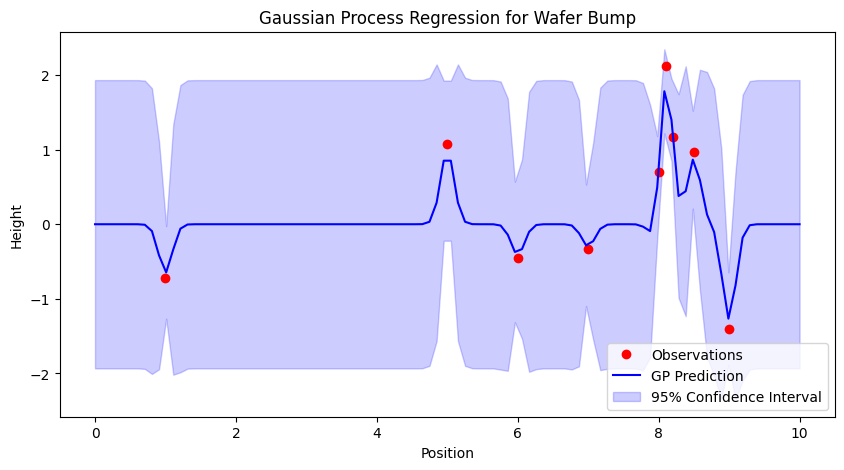

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C

# Toy Data: Sparse measurements of a wafer "bump"
X = np.array([1, 5, 6, 7, 8, 8.1, 8.2, 8.5, 9]).reshape(-1, 1)  # Positions
y = np.sin(4 * X).ravel() + np.random.normal(0, 0.5, X.shape[0])

# Define Kernel: RBF (Radial Basis Function) is standard for smooth surfaces
kernel = C(1.0) * RBF(length_scale=1e-9)
print("Initial Kernel:", kernel)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)

gp.fit(X, y)
print("Learned Kernel:", gp.kernel_)
print("Log-Marginal-Likelihood:", gp.log_marginal_likelihood(gp.kernel_.theta))
y_pred, sigma = gp.predict(np.linspace(0, 10, 100).reshape(-1, 1), return_std=True)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X, y, "ro", label="Observations")
plt.plot(np.linspace(0, 10, 100), y_pred, "b-", label="GP Prediction")
plt.fill_between(
    np.linspace(0, 10, 100),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.2,
    color="blue",
    label="95% Confidence Interval",
)
plt.title("Gaussian Process Regression for Wafer Bump")
plt.xlabel("Position")
plt.ylabel("Height")
plt.legend()
plt.show()

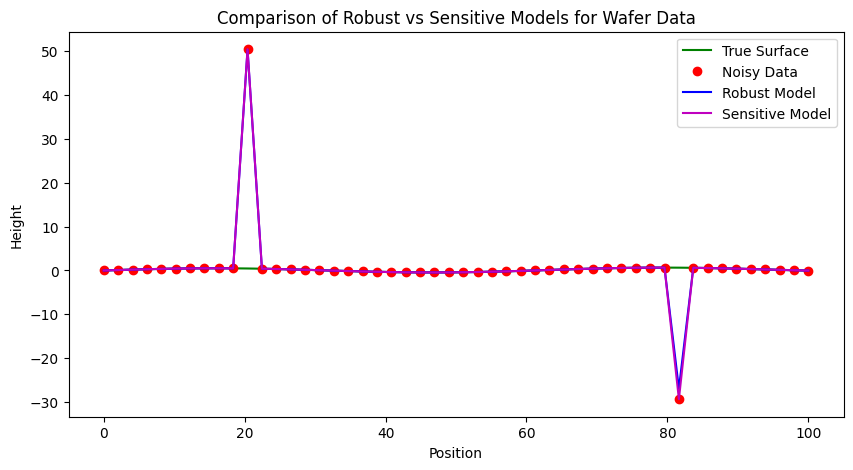

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Create Synthetic Wafer Data
x_wafer = np.linspace(0, 100, 50).reshape(-1, 1)
y_true = 0.5 * np.sin(x_wafer / 10) + (x_wafer / 200) ** 2

# 2. Add "Glitch" Outliers (The Tricky Part)
y_noisy = y_true.copy()
y_noisy[10] += 50.0  # Massive sensor glitch
y_noisy[40] -= 30.0  # Massive sensor glitch

# 3. Fit with Huber Loss (Robust) vs Least Squares (Sensitive)
model_robust = GradientBoostingRegressor(loss="huber", n_estimators=200)
model_sensitive = GradientBoostingRegressor(loss="squared_error", n_estimators=200)

model_robust.fit(x_wafer, y_noisy.ravel())
model_sensitive.fit(x_wafer, y_noisy.ravel())

# 4. Compare Results
# You will see the 'sensitive' model creates "peaks" near the glitches,
# while the 'robust' model follows the true surface of the wafer.
y_pred_robust = model_robust.predict(x_wafer)
y_pred_sensitive = model_sensitive.predict(x_wafer)

plt.figure(figsize=(10, 5))
plt.plot(x_wafer, y_true, "g-", label="True Surface")
plt.plot(x_wafer, y_noisy, "ro", label="Noisy Data")
plt.plot(x_wafer, y_pred_robust, "b-", label="Robust Model")
plt.plot(x_wafer, y_pred_sensitive, "m-", label="Sensitive Model")
plt.xlabel("Position")
plt.ylabel("Height")
plt.legend()
plt.title("Comparison of Robust vs Sensitive Models for Wafer Data")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


# ----------------------------
# 1) Synthetic wafer generator
# ----------------------------
def make_wafer(H=128, W=128, rng=None):
    rng = np.random.default_rng() if rng is None else rng

    yy, xx = np.mgrid[0:H, 0:W]
    cy, cx = H / 2, W / 2
    r = np.sqrt((yy - cy) ** 2 + (xx - cx) ** 2)

    # Base texture
    bg = 0.25 * np.cos(r / 6.0) + 0.15 * np.sin(xx / 7.0) + 0.10 * np.sin(yy / 9.0)
    bg += 0.10 * rng.normal(size=(H, W))

    # Binary mask: 1 inside wafer, 0 outside
    wafer_mask = (r <= min(H, W) * 0.46).astype(np.float32)
    img = bg * wafer_mask + (-0.8) * (1 - wafer_mask)

    img = (img - img.min()) / (img.max() - img.min() + 1e-9)
    return img.astype(np.float32), wafer_mask


def add_particle_defects(
    img, mask, wafer_mask, n=5, radius_range=(1, 4), intensity=0.9, rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    H, W = img.shape
    yy, xx = np.mgrid[0:H, 0:W]

    # Find valid indices inside the wafer to pick from
    valid_y, valid_x = np.where(wafer_mask > 0.5)

    for _ in range(n):
        # Pick a center point strictly from valid wafer pixels
        idx = rng.integers(0, len(valid_y))
        y0, x0 = valid_y[idx], valid_x[idx]

        rad = rng.integers(radius_range[0], radius_range[1] + 1)
        blob = ((yy - y0) ** 2 + (xx - x0) ** 2) <= rad**2

        # Logic: Only apply defect where (blob == True) AND (wafer_mask == 1)
        active_area = blob & (wafer_mask > 0.5)
        img[active_area] = np.clip(
            img[active_area] + intensity * (0.6 + 0.4 * rng.random()), 0, 1
        )
        mask[active_area] = 1.0
    return img, mask


def add_scratch_defect(
    img, mask, wafer_mask, n=1, thickness=1, intensity=0.7, rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    H, W = img.shape
    valid_y, valid_x = np.where(wafer_mask > 0.5)

    for _ in range(n):
        # Pick start and end points strictly inside the wafer
        idx1, idx2 = rng.integers(0, len(valid_y), size=2)
        y1, x1 = valid_y[idx1], valid_x[idx1]
        y2, x2 = valid_y[idx2], valid_x[idx2]

        t = np.linspace(0, 1, 300)
        ys = ((1 - t) * y1 + t * y2).astype(int)
        xs = ((1 - t) * x1 + t * x2).astype(int)

        for y, x in zip(ys, xs):
            # Ensure coordinates stay within array bounds
            y0, y1b = max(0, y - thickness), min(H, y + thickness + 1)
            x0, x1b = max(0, x - thickness), min(W, x + thickness + 1)

            # Constrain drawing to the wafer mask
            # We use a slice and then multiply by the local wafer mask slice
            local_wafer = wafer_mask[y0:y1b, x0:x1b] > 0.5
            img_slice = img[y0:y1b, x0:x1b]
            mask_slice = mask[y0:y1b, x0:x1b]

            img_slice[local_wafer] = np.clip(img_slice[local_wafer] + intensity, 0, 1)
            mask_slice[local_wafer] = 1.0

    return img, mask


class WaferDefectDataset(Dataset):
    def __init__(self, N=2000, H=128, W=128, defect_prob=0.7, seed=0):
        self.N, self.H, self.W = N, H, W
        self.defect_prob = defect_prob
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        rng = np.random.default_rng(self.rng.integers(0, 10**9))
        img, wafer_mask = make_wafer(self.H, self.W, rng=rng)
        mask = np.zeros((self.H, self.W), dtype=np.float32)

        if rng.random() < self.defect_prob:
            img, mask = add_particle_defects(
                img, mask, wafer_mask, n=rng.integers(2, 8), rng=rng
            )
            if rng.random() < 0.5:
                img, mask = add_scratch_defect(img, mask, wafer_mask, n=1, rng=rng)

        x = torch.from_numpy(img[None, :, :])
        m = torch.from_numpy(mask[None, :, :])
        return x, m


# ----------------------------
# 2) Tiny U-Net (encoder-decoder)
# ----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetTiny(nn.Module):
    def __init__(self, in_ch=1, out_ch=32):
        super().__init__()
        self.down1 = DoubleConv(in_ch, out_ch)  # (32, 128, 128)
        self.pool1 = nn.MaxPool2d(2)  # (32, 64, 64)
        self.down2 = DoubleConv(out_ch, out_ch * 2)  # (64, 64, 64)
        self.pool2 = nn.MaxPool2d(2)  # (64, 32, 32)

        self.mid = DoubleConv(out_ch * 2, out_ch * 4)  # (128, 32, 32)

        self.up2 = nn.ConvTranspose2d(
            out_ch * 4, out_ch * 2, 2, stride=2
        )  # (64, 64, 64)
        self.conv2 = DoubleConv(out_ch * 4, out_ch * 2)  # (64, 64, 64)
        self.up1 = nn.ConvTranspose2d(out_ch * 2, out_ch, 2, stride=2)  # (32, 128, 128)
        self.conv1 = DoubleConv(out_ch * 2, out_ch)  # (32, 128, 128)

        self.out = nn.Conv2d(out_ch, 1, 1)  # logits # (1, 128, 128)

    def forward(self, x):
        h1 = self.down1(x)  # (1, 128, 128) -> (32, 128, 128)
        h1_prime = self.pool1(h1)  # (32, 128, 128) -> (32, 64, 64)
        h2 = self.down2(h1_prime)  # (32, 64, 64) -> (64, 64, 64)
        h2_prime = self.pool2(h2)  # (64, 64, 64) -> (64, 32, 32)

        hmid = self.mid(h2_prime)  # (64, 32, 32) -> (128, 32, 32)

        u2_prime = self.up2(hmid)  # (128, 32, 32) -> (64, 64, 64)
        u2 = self.conv2(
            torch.cat([u2_prime, h2], dim=1)
        )  # (64, 64, 64) + (64, 64, 64) = (128, 64, 64) -> (64, 64, 64)
        u1_prime = self.up1(u2)  # (64, 64, 64) -> (32, 128, 128)
        u1 = self.conv1(
            torch.cat([u1_prime, h1], dim=1)
        )  # (32, 128, 128) + (32, 128, 128) = (64, 128, 128) -> (32, 128, 128)
        logits = self.out(u1)  # (32, 128, 128) -> (1, 128, 128)
        return logits


# ----------------------------
# 3) Losses: weighted BCE + Dice
# ----------------------------
def dice_loss_from_logits(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(2, 3)) + eps
    den = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + eps
    dice = (num / den).mean()
    return 1 - dice


def weighted_bce_from_logits(logits, targets, pos_weight=10.0):
    # pos_weight: weight for positive class (defect pixels)
    bce = F.binary_cross_entropy_with_logits(
        logits, targets, pos_weight=torch.tensor(pos_weight, device=logits.device)
    )
    return bce


# ----------------------------
# 4) Train
# ----------------------------
device = "xpu"
train_ds = WaferDefectDataset(N=1500, defect_prob=0.7, seed=1)
val_ds = WaferDefectDataset(N=200, defect_prob=0.7, seed=2)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

model = UNetTiny().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

LAMBDA_DICE = 1.0
POS_WEIGHT = 12.0


def eval_loss():
    model.eval()
    tot = 0.0
    with torch.no_grad():
        for x, m in val_loader:
            x, m = x.to(device), m.to(device)
            logits = model(x)
            loss = weighted_bce_from_logits(
                logits, m, POS_WEIGHT
            ) + LAMBDA_DICE * dice_loss_from_logits(logits, m)
            tot += loss.item() * x.size(0)
    return tot / len(val_ds)

In [ ]:
for epoch in tqdm(range(1), desc="Training"):
    model.train()
    for x, m in train_loader:
        x, m = x.to(device), m.to(device)
        logits = model(x)
        loss = weighted_bce_from_logits(
            logits, m, POS_WEIGHT
        ) + LAMBDA_DICE * dice_loss_from_logits(logits, m)
        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"Epoch {epoch+1:02d} | val loss: {eval_loss():.4f}")

Training: 100%|██████████| 1/1 [00:23<00:00, 23.16s/it]

Epoch 01 | val loss: 1.2763


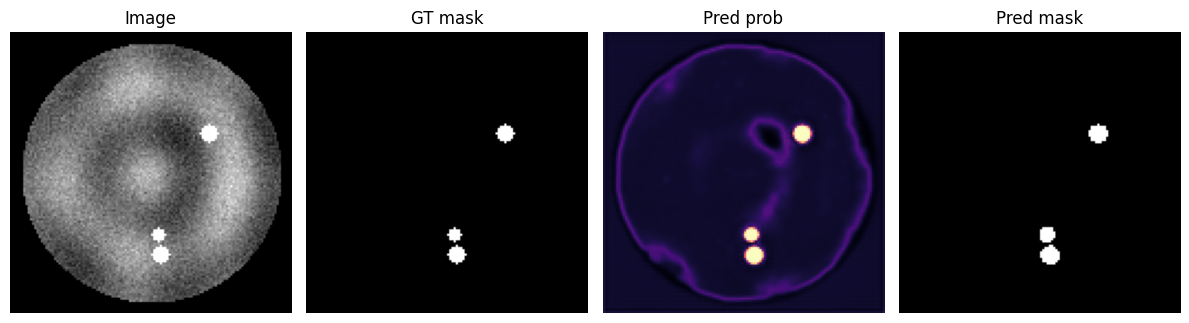

In [ ]:
val_ds = WaferDefectDataset(N=200, defect_prob=0.9, seed=np.random.randint(0, 10**9))
# ----------------------------
# 5) Visualize predictions
# ----------------------------
model.eval()
x, m = val_ds[0]
with torch.no_grad():
    logits = model(x[None].to(device))
    p = torch.sigmoid(logits).cpu().squeeze().numpy()

img = x.squeeze().numpy()
gt = m.squeeze().numpy()
threshold = 0.5
pred_mask = (p >= threshold).astype(np.float32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title("Image")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.title("GT mask")
plt.imshow(gt, cmap="gray")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.title("Pred prob")
plt.imshow(p, cmap="magma")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.title("Pred mask")
plt.imshow(pred_mask, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# print summary of model parameters
print(model)
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {num_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

UNetTiny(
  (down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
 